# Analysis of the Ca8452 line

In [1]:
import sys
sys.path.append('D:/solar flares/data/2017-09-06')
import use_nessi as un


In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
# %matplotlib inline
from astropy.io import fits as f
import sunpy
from scipy.io import readsav
import cocopy as cp
from ISPy.io import solarnet
import sunpy.map
import astropy.units as u
from scipy.io import readsav as rs
from PIL import Image, ImageEnhance
import use_nessi as un
from importlib import reload
import matplotlib.animation as animation
from PIL import Image
from scipy.interpolate import interp1d
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection


# functies uittesten met CaII

the following code block is not needed anymore. 

In [3]:
reload(un)

<module 'use_nessi' from 'D:\\solar flares/data/2017-09-06\\use_nessi.py'>

In [4]:
# And now the running commands
openfile="nb_8542_2019-05-06T08_33_15_scans=0-170_stokes_corrected_im.fits"
header= f.getheader(un.get_file_path_fits(openfile))
header = un.add_enters(str(header), length_row=79)

print(header)
# np.savetxt('headerCaK19.txt', header)

with open('headers/headerCaIR19.txt', 'w') as file:
    file.write(header)

SIMPLE  =                    T / Written by IDL:  Mon Jan 27 12:46:23 2020     
 BITPIX  =                  -32 /                                               
 NAXIS   =                    5 / Number of data axes                           
 NAXIS1  =                 1116 / Number of positions along axis 1              
 NAXIS2  =                 1070 / Number of positions along axis 2              
 NAXIS3  =                   17 / Number of positions along axis 3              
 NAXIS4  =                    4 / Number of positions along axis 4              
 NAXIS5  =                  171 / Number of positions along axis 5              
 EXTEND  =                    T / The file has extension(s).                    
 TIMESYS = 'UTC     '           /                                               
 DATE    = '2020-01-27T22:20:07' / Creation UTC date of FITS header             
 VAR_KEYS= 'VAR-EXT-DATE-BEG;DATE-BEG,VAR-EXT-DATE-END;DATE-END,VAR-EXT-DATE-AV&
'CONTINUE  'G;DATE-AVG,VAR-EX

 [astropy.io.fits.verify]


 thus falling back to mode='denywrite', which means that the array will be read-only [astropy.io.fits.file]


the found wavelengts by solarnet where  [854.13   854.1425 854.155  854.1625 854.17   854.1775 854.185  854.1925
 854.2    854.2075 854.215  854.2225 854.23   854.2375 854.245  854.2575
 854.27  ]


(1070, 1116) (1070, 1116)
Boundary
Blue=Outside, yellow=Inside


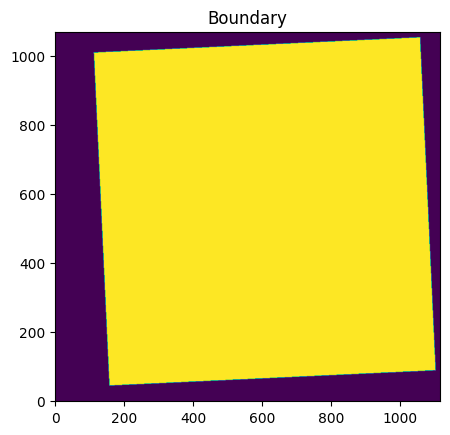

If there is still boundary left to be excluded, call self.second_boundary()
The next thing to do is to initalise the filters. Use update_filters(self, MeanSd, form='normal')
910331


In [5]:

# %matplotlib widget
CaII = un.SST_data('nb_8542_2019-05-06T08_33_15_scans=0-170_stokes_corrected_im.fits',
                   'use_solarnet','use_solarnet', name_of_line='CaIR19', thresh=[1e-7, 5e-5])


# Here the wavelengths are writen in nm in stead of angstroms
CaII._wavel =10 * CaII._wavel

# CaII.datacube
CaII.boundary
print(np.sum(CaII.boundary))

We are now cutting a bit of the boundary such that it is in the intersection of all frames and that we do not take noise frome the sides in our calculations. 
However. We have to weight the area factor a little bit to account for this.

---------------------------------

Start from here onwards

In [6]:

s = np.sum(CaII.boundary)
areafactor = s/847550 * 60**2 / (np.pi*950**2)

print(s, 'percentage of frame kept:', s/847550, 'areafactor:', areafactor) # to account for a bit of extra non excluded pixels


# CaII.datacube[70,0,:,600,600]

910331 percentage of frame kept: 1.0740735059878472 areafactor: 0.0013637646267018948


In [7]:
def gess_filters(n_wav):
    sd = n_wav/8
    return [[n_wav/6 - 0.5, sd], [3 * n_wav/6 - 0.5, sd], [5 * n_wav / 6 - 0.5, sd]]



[[5, 0.9], [8.0, 0.9], [11, 0.9]] 17


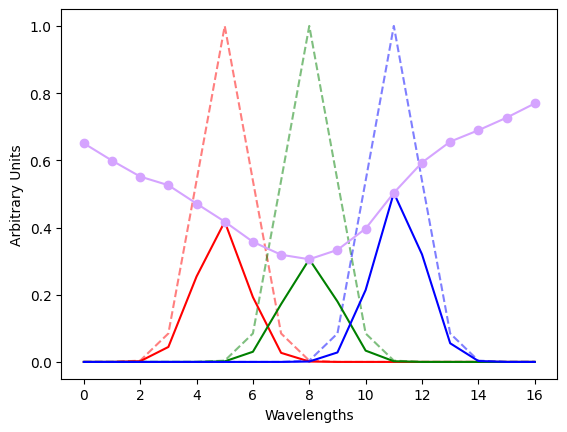

In [8]:
# %matplotlib inline
Meansd = gess_filters(len(CaII._wavel))
Meansd = [[5, 0.9], [8.0, 0.9], [11, 0.9]]
print(Meansd,len(CaII._wavel) )
CaII.update_filters(Meansd)
CaII.plot_filt(880,900)

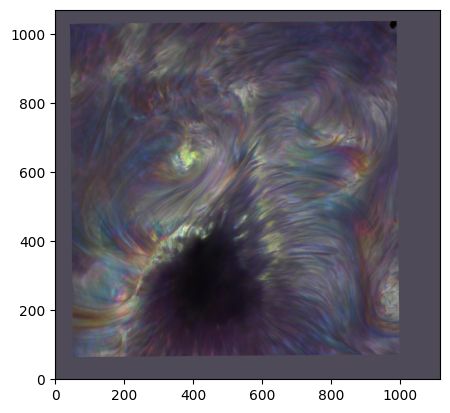

In [9]:
%matplotlib inline

CaII.ccp_frame(70,Show=False)
CaII.thresh=[1e-7,2e-5]
plt.imshow(CaII.current_ccp[:,:], origin='lower')
# plt.imshow(CaII.boundary[::-1,:], alpha=0.2)
plt.show()

#interesting pixel: (1030, 975)

In [10]:
from random import randint

# frame is an integer, the frame number
# pixels is an array listing [x,y] of the pixels of which the spectrum is to appear
def interesting_pixels(self, frame, pixels=[], rand=False, numb=5):
    if rand:
        xmax=np.shape(self.datacube)
        ymax=xmax[3]
        xmax = xmax[4]
        for i in range(numb):
            pixels.append([randint(0,xmax-1), randint(0, ymax-1)])
    else:
        numb = len(pixels)
    self.ccp_frame(frame,Show=False)
    colors=self.current_ccp

    fig, ax = plt.subplots(1)
    ax.set_title("spectral lines of some pixels: "+ self.time_of_frame(frame) )
    if len(pixels)>0:
        if hasattr(self, 'correction'):
            corr = self.correction
        else:
            corr = self._wavel*0
    for p in range(numb):
        print(f'the collor will be {colors[pixels[p][1]][pixels[p][0]]/255} but maybe better {colors[pixels[p][1]][pixels[p][0]]/255/2}')
        ax.plot(self._wavel, self.datacube[frame,0, :, pixels[p][1], pixels[p][0]]+self.scalar*corr,color=colors[pixels[p][1]][pixels[p][0]]/255/2,
                label="pixel x="+str(pixels[p][0])+" y="+str(pixels[p][1]))
    if hasattr(self, 'line_lim'):
        ax.set_xlim(self.line_lim)
    ax.set_xlabel(r"wavelength [$\rm\AA$]")
    ax.set_ylabel("intensity [units???]")
    if numb<6:
        ax.legend(fontsize=6)
    plt.show()


the collor will be [0.30980392 0.29019608 0.34509804] but maybe better [0.15490196 0.14509804 0.17254902]
the collor will be [0.30980392 0.29019608 0.34509804] but maybe better [0.15490196 0.14509804 0.17254902]
the collor will be [0.30980392 0.29019608 0.34509804] but maybe better [0.15490196 0.14509804 0.17254902]
the collor will be [0.23921569 0.24313725 0.32941176] but maybe better [0.11960784 0.12156863 0.16470588]
the collor will be [0.17647059 0.16078431 0.24705882] but maybe better [0.08823529 0.08039216 0.12352941]
the collor will be [0.32941176 0.3254902  0.39215686] but maybe better [0.16470588 0.1627451  0.19607843]
the collor will be [0.26666667 0.23137255 0.31764706] but maybe better [0.13333333 0.11568627 0.15882353]
the collor will be [0.33333333 0.35686275 0.38039216] but maybe better [0.16666667 0.17843137 0.19019608]
the collor will be [0.4        0.38823529 0.44313725] but maybe better [0.2        0.19411765 0.22156863]
the collor will be [0.23137255 0.19607843 0.31

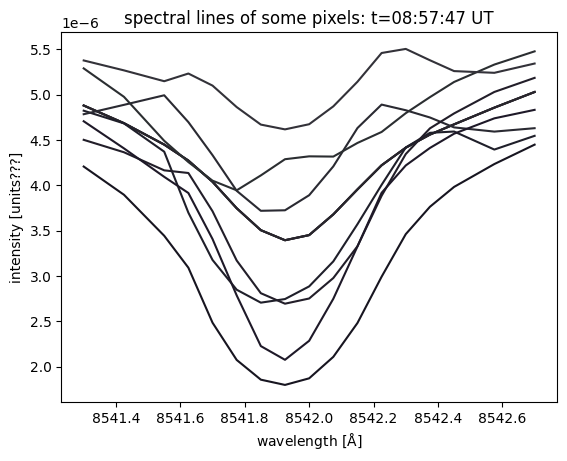

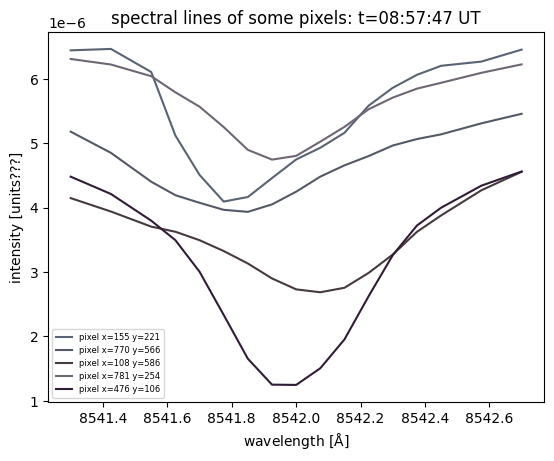

In [11]:
interesting_pixels(self= CaII, frame=70, pixels=[(1030, 975)], rand=True, numb=10)
CaII.interesting_pixels( frame=70, pixels=[(1030, 975)], rand=True, numb=5)

COCOPLOT at  t=08:33:21 UT (frame number 0 )


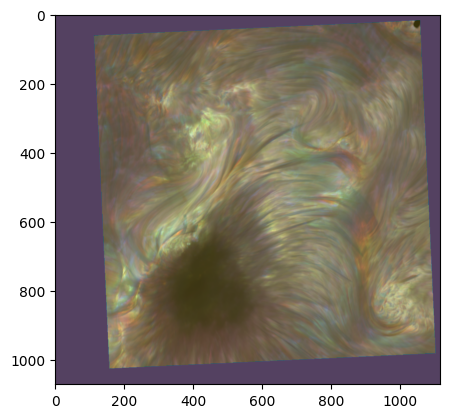

COCOPLOT at  t=08:47:19 UT (frame number 40 )


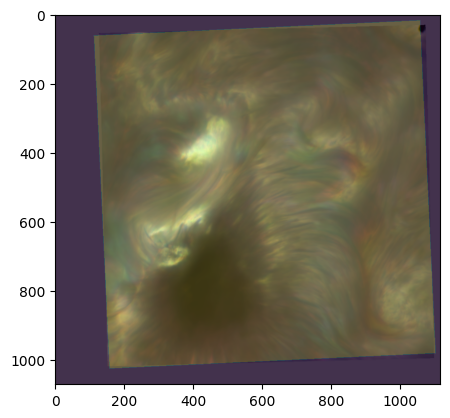

COCOPLOT at  t=09:01:16 UT (frame number 80 )


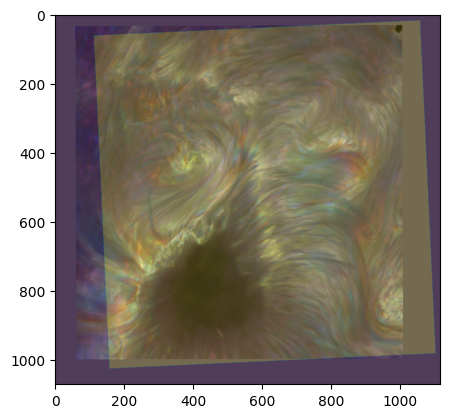

COCOPLOT at  t=09:15:13 UT (frame number 120 )


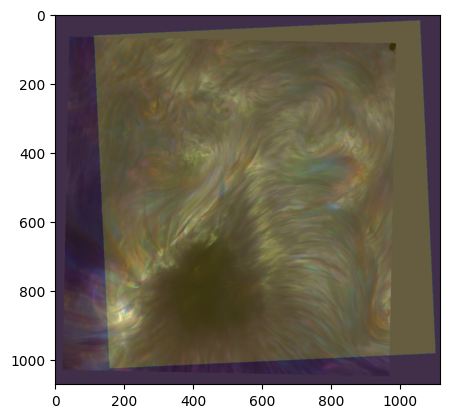

COCOPLOT at  t=09:29:11 UT (frame number 160 )


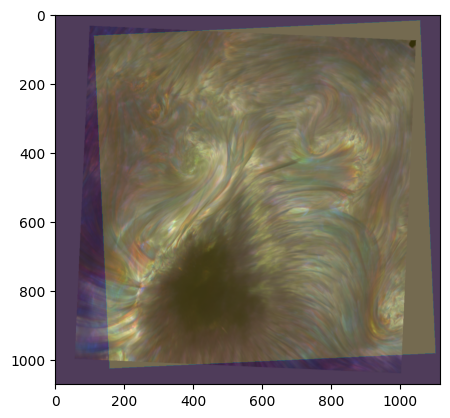

In [12]:
# Many COCOPLOTS
r = CaII._number_of_frames
for i in range(0,r,40):
    tstr = CaII.time_of_frame(i)
    print("COCOPLOT at ", tstr, "(frame number", i,")")
    CaII.ccp_frame(i,Show=False)
    plt.imshow(CaII.current_ccp[::-1,:])

    plt.imshow(CaII.boundary[::-1,:], alpha=0.2)
    plt.show()


COCOPLOT at  t=08:57:47 UT (frame number 70 )


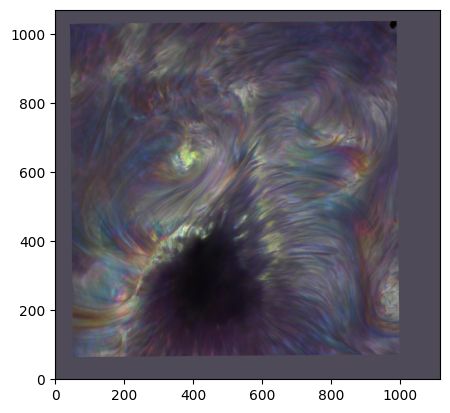

In [13]:
CaII.ccp_frame(70)
pixels=[[30,60],[631,646],[194,268],[298,323],[472,204]]
# CaII.current_ccp[0:30:5,0:60:5,:]

In [14]:
# print(pixels)
# x=[]
# frame = 70
# for frame in range(0,213,40):
#     print('frame:',frame)
#     for i in pixels:
#         x.append(CaII.datacube[frame,0,10,i[1],i[0]] - CaII.datacube[frame,0,0,i[1],i[0]])
#         print(i, x[-1])
# CaII.interesting_pixels(frame, pixels, rand=False, numb=30)
# mx = np.mean(x)
# correction = - mx * (CaII._wavel - CaII._wavel[0])
# print(CaII._wavel, correction)

# frame = 70

# print(frame)
# colors = CaII.ccp_frame(frame,Show=False)

# fig, ax = plt.subplots(1)
# ax.set_title("spectral lines of some pixels: "+ CaII.time_of_frame(frame) )
# for p in range(len(pixels)):
#     ax.plot(CaII._wavel, CaII.datacube[frame,0, :, pixels[p][1], pixels[p][0]] + correction,
#             label="pixel x="+str(pixels[p][0])+" y="+str(pixels[p][1]))
# ax.set_xlabel(r"wavelength [$\rm\AA$]")
# ax.set_ylabel("intensity [units???]")
# ax.legend(fontsize=6)
# plt.show()

In [15]:
print('1',end='\rt')
print('10 ',end='')
print('\r\r\r11 ',end='')
j=12
s = ''
for i in range(len(str(j))+1):
    s += '\r'
print(s, end=str(j))

12  

In [16]:
CaII.calculate__FOV_spect_over_time()

# try :
#     FOV_spectrum = np.load('FOV_spectrum_CaII.npy')
# except:
#     # time_av_spectrum = np.array([Ha.frame_integrated_spect(frame)/Ha.scalar for frame in range(213)])
#     FOV_spectrum=[]
#     for frame in range(np.shape(CaII.datacube)[0]):
#         s=''
#         for i in range(len(str(frame))+1):
#             s += '\r'
#         print(s, end=str(frame))
#         FOV_spectrum.append(CaII.frame_integrated_spect(frame)/CaII.scalar)

#     FOV_spectrum = np.array(FOV_spectrum)
#     np.save('FOV_spectrum_CaII.npy', FOV_spectrum)
# np.shape(FOV_spectrum), CaII.scalar

Make sure the following correction is added only once! However adding it a second time should not differ it.

In [17]:
# def add_correction(CaII, FOV_spectrum, theoretical_difference):
#     if hasattr(CaII, 'correction'):
#         print('the correction has already been done ')
#         return FOV_spectrum, CaII.correction

#     mean_difference_observation = np.mean(FOV_spectrum[:,-1]-FOV_spectrum[:,0])
#     print(mean_difference_observation, theoretical_difference)

#     correction = -(mean_difference_observation - theoretical_difference) * (CaII._wavel - CaII._wavel[0])

#     FOV_spectrum = FOV_spectrum + correction
#     CaII.correction = correction
#     return FOV_spectrum, correction

FOV_spectrum, correction = CaII.add_correction(theoretical_difference=0.03497400310369425)



In [18]:
print(correction)

[0.         0.00101395 0.00202791 0.00263628 0.00324465 0.00385302
 0.00446139 0.00506977 0.00567814 0.00628651 0.00689488 0.00750325
 0.00811163 0.00872    0.00932837 0.01034232 0.01135628]


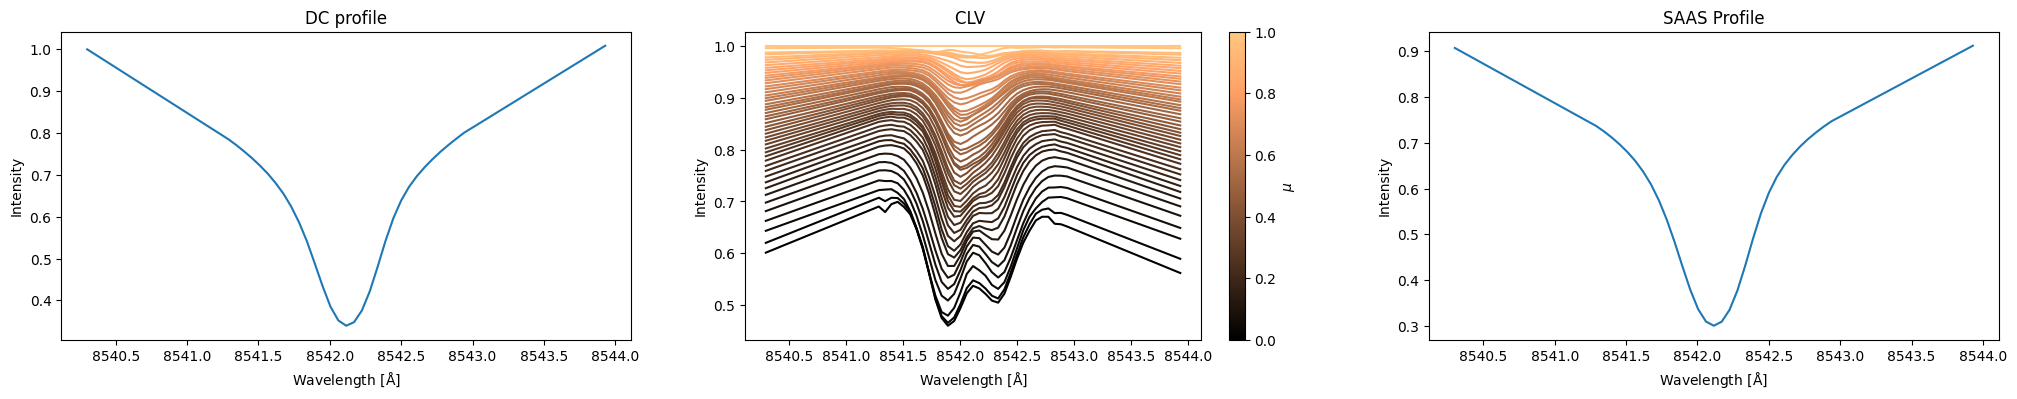

crisp::read_reflectivity: (RL,RH)[8542.114877954633] = (0.851550166761555, 0.9299031666516842)


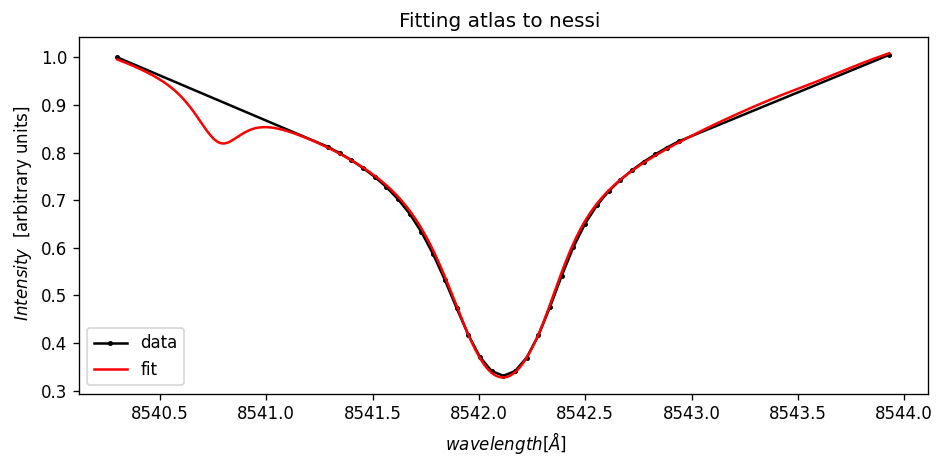

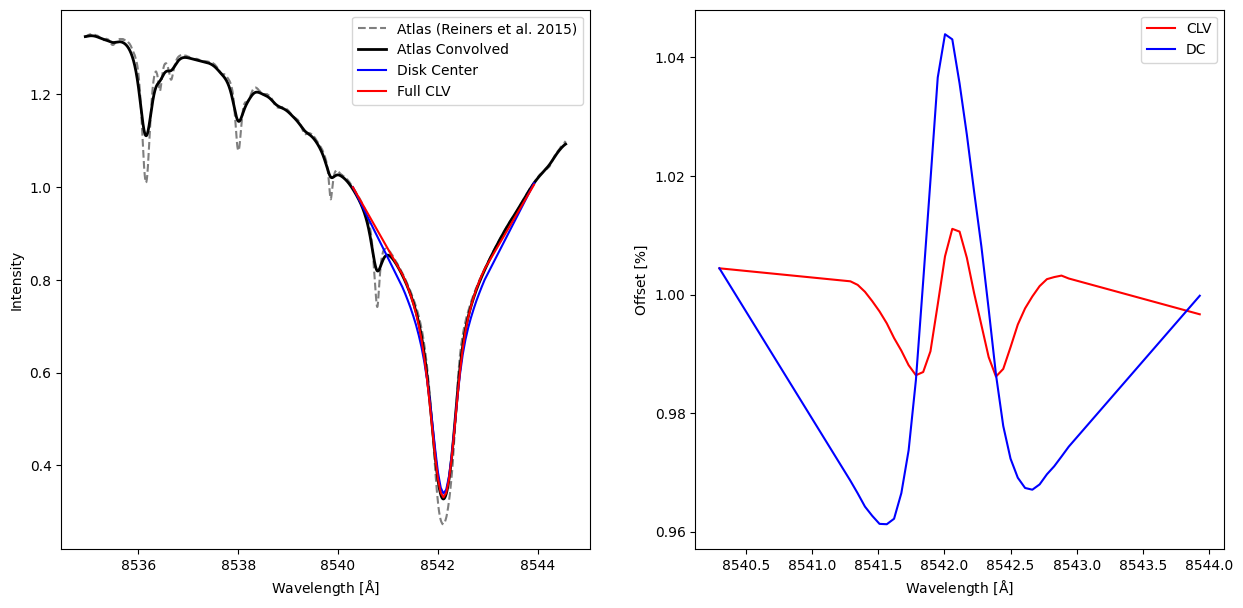

In [19]:
theor_CaII = un.linestudier('8542_clv.fits', nr=101)
theor_CaII.saas_profile_atlas_check(show_all=False, initial_values_fit=np.array([-2.364e+00,  1.412e-02,  1.380e+00]))

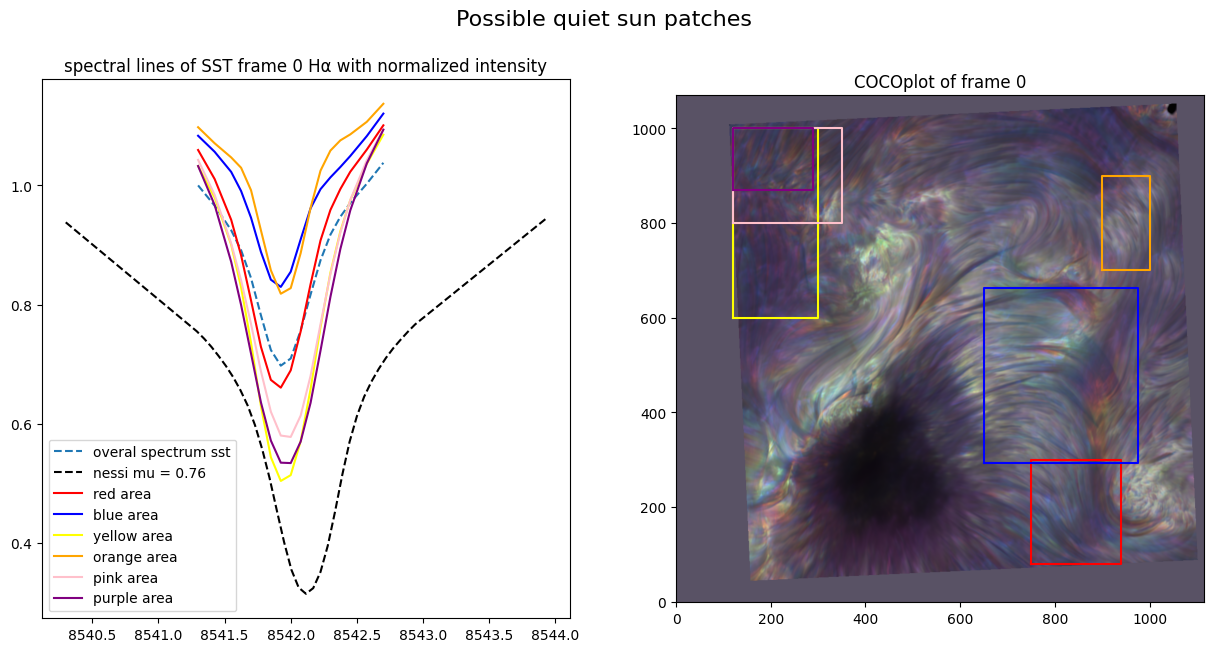

In [20]:
# %matplotlib widget
# %matplotlib inline
frame = 0

X = [[(750,940), (80,300)], [(650,975), (294,662)],[(120,300), (600,1000)], [(900, 1000), (700, 900)], [(120,350), (800,1000)] 
     , [(120,290), (870,1000)]]

CaII.possible_quiet_sun_patches(frame, theor_line = theor_CaII, X=X)

In [21]:
# the chosen quiet sun patch is 
color_wanted_patch = "yellow"

# choose from
colors=['red', 'blue', 'yellow', 'orange', 'pink', 'purple', 'limegreen', 'darkgreen', 'gray']

the edges of the patch are denoted by the xlim: (120, 300) and ylim: (600, 1000)


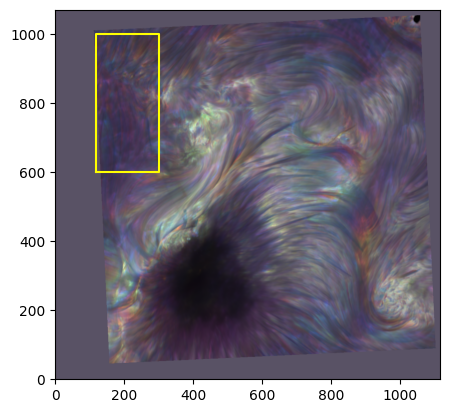

In [22]:
ind = int(colors.index(color_wanted_patch))

xlim, ylim = X[ind]
print('the edges of the patch are denoted by the xlim:', xlim, 'and ylim:', ylim)
CaII.set_quiet_sun(frame, xlim, ylim, show=False, color=color_wanted_patch)

## Finding $\mu$

(171, 4, 17, 1070, 1116)
The frame is centered at (-716.921986496582, 186.15625469630433)


 thus falling back to mode='denywrite', which means that the array will be read-only [astropy.io.fits.file]


[-749.925986496582, -683.917986496582, 154.51385469630432, 217.79865469630434]
AVERAGE MU: The average $\mu$ wheigthed over the field of view is 0.6382678277703728 for timeframe 0
The frame is centered at (-716.921986496582, 186.15625469630433)
[-749.925986496582, -683.917986496582, 154.51385469630432, 217.79865469630434]
AVERAGE MU: The average $\mu$ wheigthed over the field of view is 0.6382678277703728 for timeframe 170
We take average mu to be  0.6382678277703728
Mu also set to the theoretic nessi line.


(0.6382678277703728, array([18], dtype=int64))

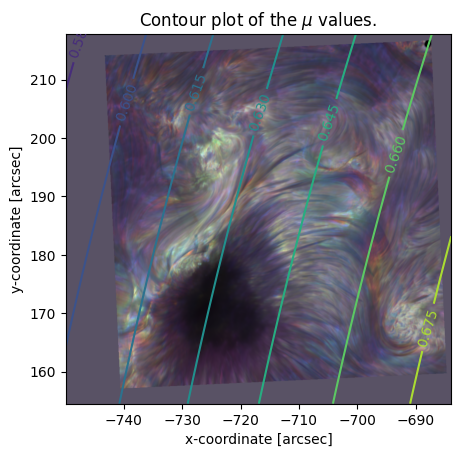

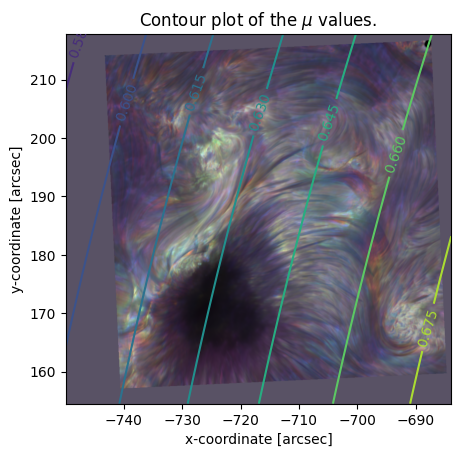

In [23]:
print(np.shape(CaII.datacube))
mu = CaII.set_mu(theor_line=theor_CaII, number_of_last_frame=170)
x = np.abs(theor_CaII.sst_mu-mu)
index_mu = np.where(x == np.min(x))[0]
mu, index_mu

Best fitting mu is 0.64


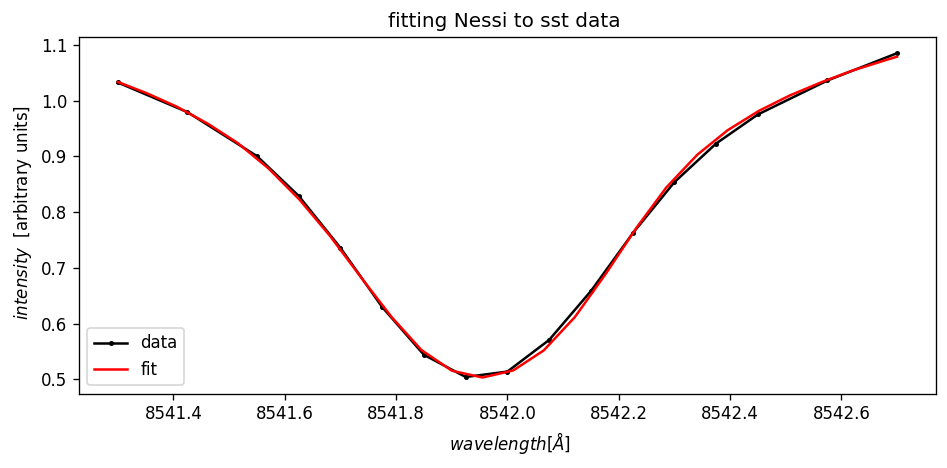

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 20.36343514517127
        x: [-1.595e-01  1.106e-01  1.326e+00]
      nit: 17
      jac: [ 6.199e-06 -1.907e-06 -7.153e-07]
 hess_inv: [[ 2.312e-06 -4.475e-06  7.331e-06]
            [-4.475e-06  1.526e-05 -2.238e-05]
            [ 7.331e-06 -2.238e-05  3.583e-05]]
     nfev: 204
     njev: 51
de p-waarde is  0.9999886628972381 
Chi^2 reduced= 1.4545310817979478 
aantal vrijheidgraden= 14 
chi^2= 20.36343514517127
we behouden de fit tot op een betrouwbaarheidsniveau van  0.9999886628972381 
Oftewel verwerp als p-waarde <lpha-niveau 


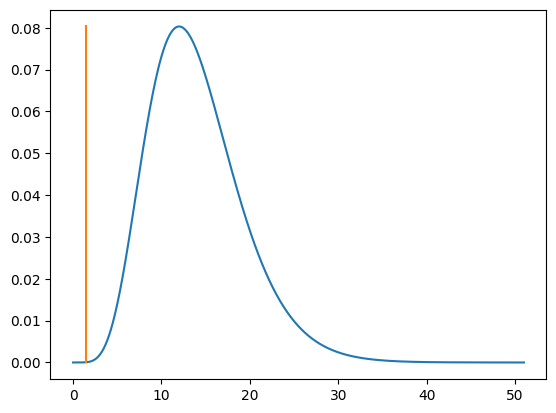

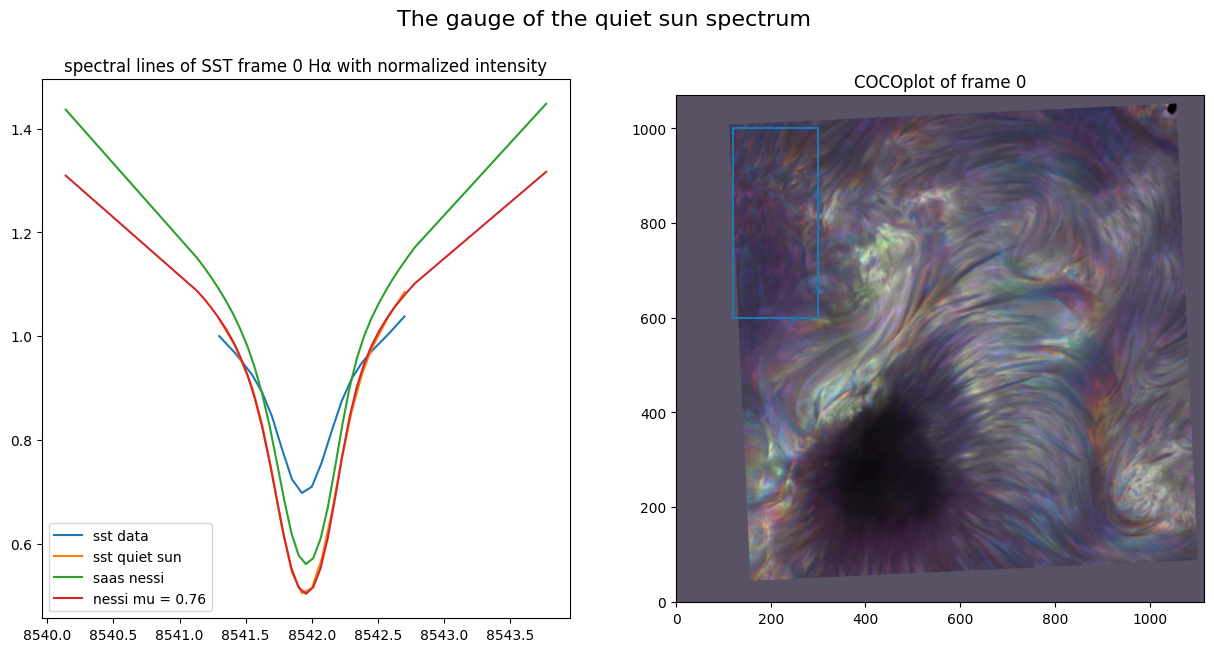

In [24]:
mini, f_nessi_theta, f_nessi_clv_theta = CaII.fit_nessi_to_quiet_sun( theor_line = theor_CaII,
                                                                     initial_values=np.array([-2.349e-01 , 5.072e-01,  8.865e-01]))

In [25]:
# calculation the theoretical difference
f_nessi_clv_theta(CaII._wavel[-1]) - f_nessi_clv_theta(CaII._wavel[0])

0.04521294468884607

if integrated in the full disk spectrum the maximal deviation is  0.014451005209714651 %.


Text(0.5, 1.0, 'COCOplot')

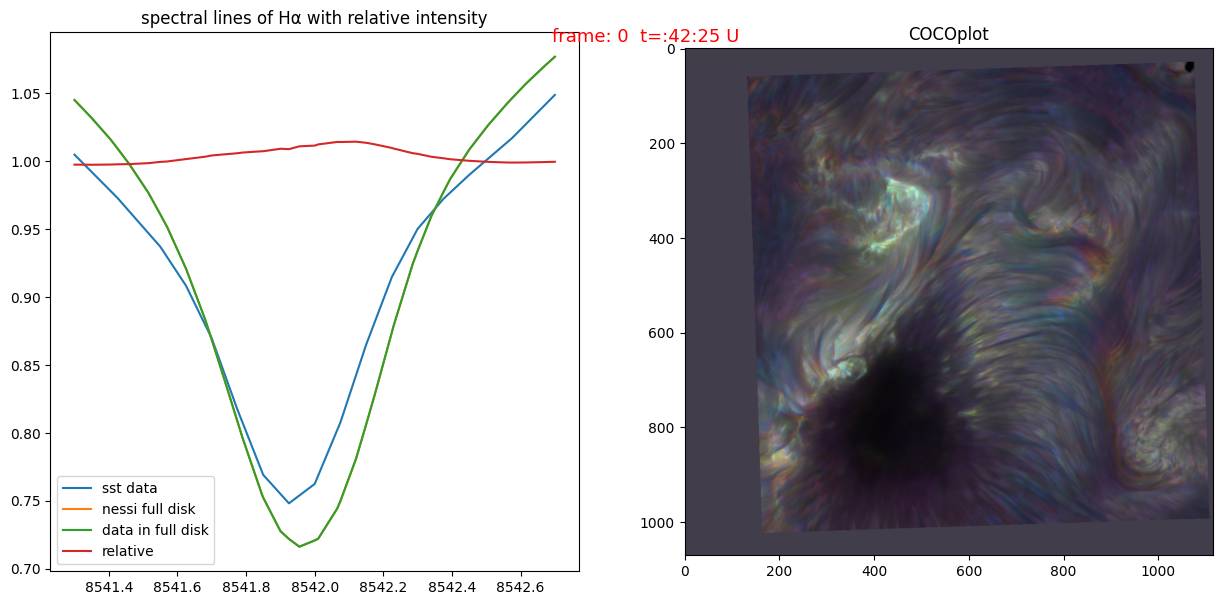

In [26]:
theor_line = theor_CaII
CaII = CaII
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 7))
frame = 26

CaII.frame_integrated_spect(frame)
CaII.ccp_frame(frame,Show=False)



wav = un.merge_wavelengths(CaII._wavel, theor_line.sst_wav+ CaII.theta_nessi_to_quiet_sun[0])


f_nessi_clv = lambda theta: interp1d(theor_line.sst_wav + theta[0], theta[2] * theor_line.sst_dc*theor_line.sst_clv[12] + theta[1]
                                  , kind='linear', fill_value="extrapolate")
f_nessi = lambda theta: interp1d(theor_line.sst_wav + theta[0], theta[2] * theor_line.sst_dc + theta[1]
                                  , kind='linear', fill_value="extrapolate")
f_sst = interp1d(CaII._wavel, CaII.av_spect/CaII.scalar, kind='linear', fill_value="extrapolate")



# line_sst, = ax[0, 0].plot(CaII._wavel, CaII.av_spect/CaII.scalar, '--', label='sst data')
# ax[0, 0].plot(theor_line.sst_wav + theta[0], theta[2] * theor_line.sst_dc*theor_line.sst_clv[12] + theta[1], label='nessi mu = 0.76')
# ax[0, 0].plot(wav, f_nessi(theta)(wav), label='nessi full disk')

theta = [-1.561e-01,  4.360e-01,  8.237e-01]

a=CaII.current_ccp
im = ax[1].imshow(Image.fromarray(a[::-1,:]), interpolation='none', aspect='auto', vmin=0, vmax=1)

# Ha.ccp_frame(frame,Show=False)
_tstr=(f"Ca t={CaII._time[frame][0:-7]} UT")

_tstr=_tstr[2:5]+_tstr[7:15]+_tstr[16:]
scaler = 2.7306518951052202e-08
ax[1].text(-280,-15,"frame: 0 "+_tstr, fontsize=13, color='red')

ax[0].set_title("spectral lines of H\u03B1 with relative intensity")

ax[0].plot(wav, f_sst(wav), label='sst data')
ax[0].plot(wav, f_nessi(theta)(wav), label='nessi full disk')



# f_sst_full = lambda theta : f_nessi(theta) + areafactor * (f_sst - f_nessi_clv(theta))
# f_relative = lambda theta : f_sst_full(theta) / f_nessi(theta)
sst_full = f_nessi(theta)(wav) + areafactor * (f_sst(wav) - f_nessi_clv(theta)(wav))
relative = sst_full / f_nessi(theta)(wav)
print("if integrated in the full disk spectrum the maximal deviation is ",  (np.max(relative)-1)*100, '%.')

ax[0].plot(wav, sst_full , label='data in full disk')
ax[0].plot(wav, ((f_nessi(theta)(wav) + areafactor * (f_sst(wav) - f_nessi_clv(theta)(wav))) / f_nessi(theta)(wav)-1)*100+1, label='relative')

ax[0].legend(loc='lower left')
# ax[0].set_xlim([6561, 6565])
# ax[0].set_ylim([0.2, 1.5])
ax[1].imshow(Image.fromarray(CaII.current_ccp[::-1,:]))
ax[1].set_title("COCOplot")

The full FOV integrated spectrum over time:

In [27]:
CaII = CaII
np.shape(CaII.datacube)

(171, 4, 17, 1070, 1116)

# Figure 4 In HARPS ALEX
![Schermafbeelding 2023-11-26 093811.png](<attachment:Schermafbeelding 2023-11-26 093811.png>)

Now we do it for the FOV spectum with as normalisation the quiet sun
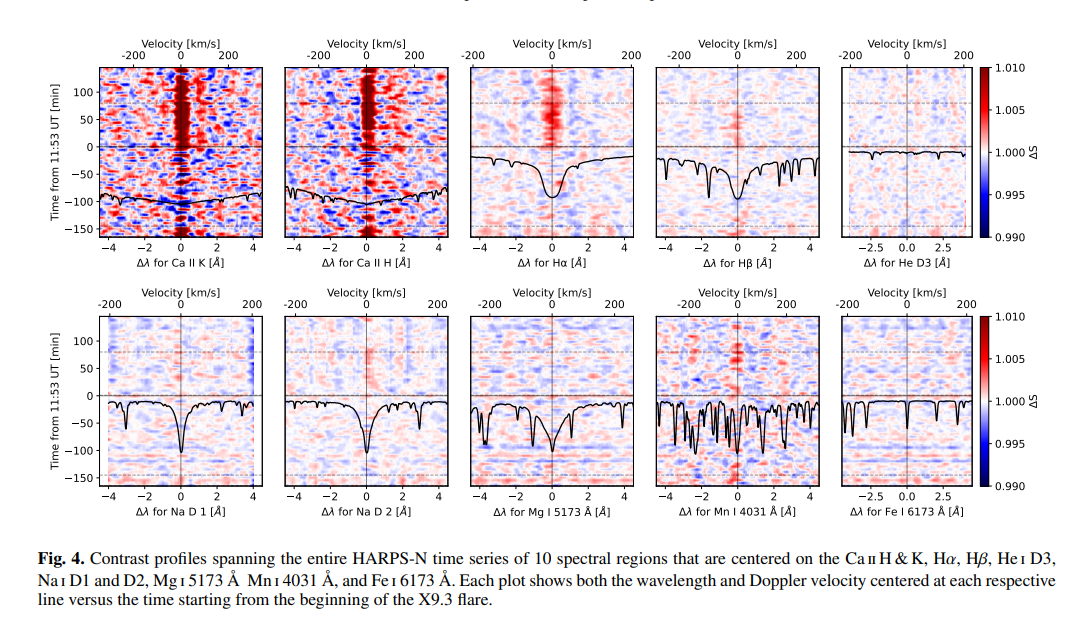

In [28]:
# from matplotlib import cm
# import matplotlib.cbook as cbook
# import matplotlib.colors as colors

# # CaII = CaII

# theta = [-1.708e-01,  4.528e-01,  8.349e-01]# [ 1.750e-01,  1.487e-01,  9.732e-01]
# theor_line = theor_CaII

# f_nessi_clv = interp1d(theor_line.sst_wav + theta[0], theta[2] * theor_line.sst_dc*theor_line.sst_clv[12] + theta[1]
#                                   , kind='linear', fill_value="extrapolate")

# QS = f_nessi_clv(CaII._wavel)
# FOV_spectrum = CaII.FOV_spectrum

# Z = FOV_spectrum - QS
# x = CaII._wavel

# def hulp_time(string):
#     return float(string[:2])*60 + float(string[3:5]) + float(string[6:8])/60

# def time_to_minutes(_time):
#     return np.array([ hulp_time(t) for i,t in enumerate(_time) ])

# TIME = time_to_minutes(CaII._time)[3:216] - 716.58333333
# y = TIME
# X, Y = np.meshgrid(x, y)
# # print(X,Y)

# fig, ax = plt.subplots(1, 1)

# # pcm = ax[0].pcolormesh(X, Y, Z,
# #                        norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
# #                                               vmin=-1.0, vmax=1.0, base=10),
# #                        cmap='RdBu_r', shading='auto')
# # fig.colorbar(pcm, ax=ax[0], extend='both')


# pcm = ax.pcolormesh(X, Y, Z, cmap='RdBu_r', vmin=-np.max(Z), shading='auto')
# fig.colorbar(pcm, ax=ax, extend='both')
# ax.set_title(r'Contrast profile of Ca 8542 line, FOV sst.')
# ax.set_ylabel('Time from 11:56:35 UT on [min]')
# ax.set_xlabel(r'Wavelength [$\AA$]')

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'black'
# ax2.set_ylabel('Intensity []', color=color)  # we already handled the x-label with ax1
# ax2.plot(x,QS, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# # Delta lambda / lambda = v / c

# c = 3e5 #m/s
# linecenter = 8541.944099083514 # x[np.where(QS == np.min(QS))[0][0]]
# print(linecenter)
# velocity = c * (x - linecenter) / linecenter

# ax3 = ax2.twiny()
# ax3.plot(velocity,QS, color=color, alpha=0)  # Use the same y-data
# ax3.set_xlabel('Doppler Shift (km/s)')
# ax3.tick_params(axis='x')

# fig.tight_layout()
# plt.show()

In [29]:

# wav = un.merge_wavelengths(CaII._wavel, theor_line.sst_wav+ CaII.theta_nessi_to_quiet_sun[0])

# f_nessi_clv = lambda theta: interp1d(theor_line.sst_wav + theta[0], theta[2] * theor_line.sst_dc*theor_line.sst_clv[12] + theta[1]
#                                   , kind='linear', fill_value="extrapolate")
# f_nessi = lambda theta: interp1d(theor_line.sst_wav + theta[0], theta[2] * theor_line.sst_dc + theta[1]
#                                   , kind='linear', fill_value="extrapolate")

# print(np.shape(FOV_spectrum), FOV_spectrum[0], CaII._wavel)
# # print([(interp1d(CaII._wavel, FOV_spectrum[0], kind='linear', fill_value="extrapolate")(wav)) for i in range(np.shape(FOV_spectrum)[0])])
# # print(f_sst(wav))




# QS_clv = f_nessi_clv(theta)(wav)
# # print([f_nessi(theta)(wav) + areafactor*(interp1d(CaII._wavel, FOV_spectrum[i], kind='linear', fill_value="extrapolate")(wav) - QS_clv)
# #                         for i in range(np.shape(FOV_spectrum)[0])])

# Z_full_disk = np.array([areafactor*(interp1d(CaII._wavel, FOV_spectrum[i], kind='linear', fill_value="extrapolate")(wav) - QS_clv)
#                         for i in range(np.shape(FOV_spectrum)[0])])
# x = wav
# y = TIME
# X, Y = np.meshgrid(x, y)
# # print(X,Y)

# fig, ax = plt.subplots(1, 1)

# # pcm = ax[0].pcolormesh(X, Y, Z,
# #                        norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
# #                                               vmin=-1.0, vmax=1.0, base=10),
# #                        cmap='RdBu_r', shading='auto')
# # fig.colorbar(pcm, ax=ax[0], extend='both')


# pcm = ax.pcolormesh(X, Y, Z_full_disk, cmap='RdBu_r', vmin=-np.max(Z_full_disk), shading='auto')
# fig.colorbar(pcm, ax=ax, extend='both')
# ax.set_title(r'Contrast profile of Ca 8542 line, full disk.')
# ax.set_ylabel('Time from 11:56:35 UT on [min]')
# ax.set_xlabel(r'Wavelength [$\AA$]')

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

# color = 'black'
# ax2.set_ylabel('Intensity []', color=color)  # we already handled the x-label with ax1
# ax2.plot(x,f_nessi(theta)(wav), color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()
# plt.show()

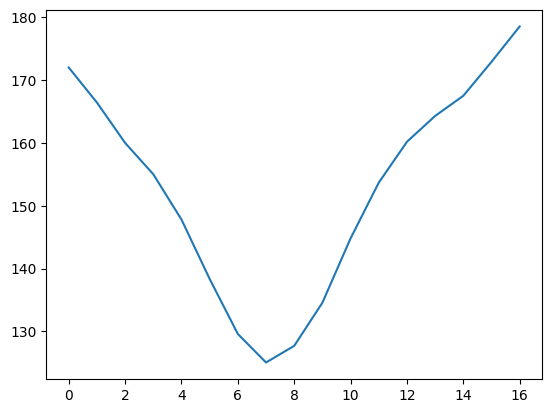

In [30]:
Tot = np.sum(FOV_spectrum, axis=0)
plt.plot(Tot)

In [31]:
# print(wav[np.where(QS_clv == np.min(QS_clv))[0][0]])

In [32]:
# filename = un.get_file_path_line_data(CaII.name_of_line)
# np.save(filename, np.array([x,f_nessi(theta)(wav)]))

# Equivalent width

The frame integrated spectrum:
$$f(t,\lambda,A) = \int_A I(t,\lambda,\vec{x})d\vec{x}$$

weight against a continuum wavelength
$$F(t,\lambda,A) = \frac{f(t,\lambda,A)}{f(t,\lambda_\text{cont},A)} \times f(t_0,\lambda_\text{cont},A)$$

Target Region wieghted against a quiet region to find relative intensity
$$F_{TR}(t, \lambda) = \frac{F(t,\lambda,A = TR)}{F(t,\lambda,A = QR)} \times F(t_0,\lambda,A=QR)$$
This we do both with the scalar multiplication to find relative intensities

The difference in spectrum in time (we do spectrum - quiet sun)
$$\Delta F=  F_{TR}(t,\lambda) - F_{TR}(t_0,\lambda)$$

weighing it again against a reference intensity. (We incorporate this is the scalar weight)
$$\Delta S(t,\lambda) = \Delta F_{TR}(t,\lambda)/F(t_0,\lambda_\text{cont},A=\text{ full disk})$$

The equivalent width is defind as the integral over the resulting normalized pre-event-subtracted H$\alpha$ spectrum
$\Delta S(t, \lambda)$ represents the ratio of the spectral changes coming from
active events to the solar irradiance (full-disk continuum). 
$$ \Delta EW_{H\alpha \pm \Delta \lambda } = \int_{H\alpha - \Delta \lambda}^{H\alpha + \Delta \lambda} \Delta S(t,\lambda ) d\lambda $$ 


To obtain something analogous (or even maybe equivalent although only a function of the line center.) We could integrate over the difference of NESSI+sst - NESSI.








In [33]:
import scipy

def differenced_equivalent_width(CaII, f_nessi_theta, f_nessi_clv_theta, wav, Dlambda):

    line_center = wav[np.where(f_nessi_theta(wav) == np.min(f_nessi_theta(wav)))[0][0]]
    interval = [line_center-Dlambda, line_center+Dlambda]

    DEW = []

    for frame in range(CaII._number_of_frames):
        DS = areafactor * (interp1d(CaII._wavel, CaII.FOV_spectrum[frame])(wav) - f_nessi_clv_theta(wav))

        x, restx = un.restrict_intervalx2(interval, wav)

        DEW.append( scipy.integrate.simpson(y=restx(DS), x=x, dx=1.0, axis=-1, even='avg'))

    return DEW


In [34]:
# DEW = differenced_equivalent_width(CaII = CaII, f_nessi_theta = f_nessi_theta, f_nessi_clv_theta=f_nessi_clv_theta, wav=wav, Dlambda= 0.5)

# fig = plt.figure()
# ax1 = fig.add_axes((0,0,1,1))
# ax1.plot(TIME, DEW, '-o', color='r', label=r'$\Delta EW$', markersize=3)
# ax1.set_title(r'Time evolution of the $\Delta EW $ with $\Delta \lambda = 0.5 \AA$ for the Ca 8542 line. ')
# ax1.set_xlabel('Time from 11:56:35 UT on [min]')
# ax1.set_ylabel(r'$\Delta EW$ $[\AA]$')
# # ax1.legend()
# plt.show()

# Best possible interval
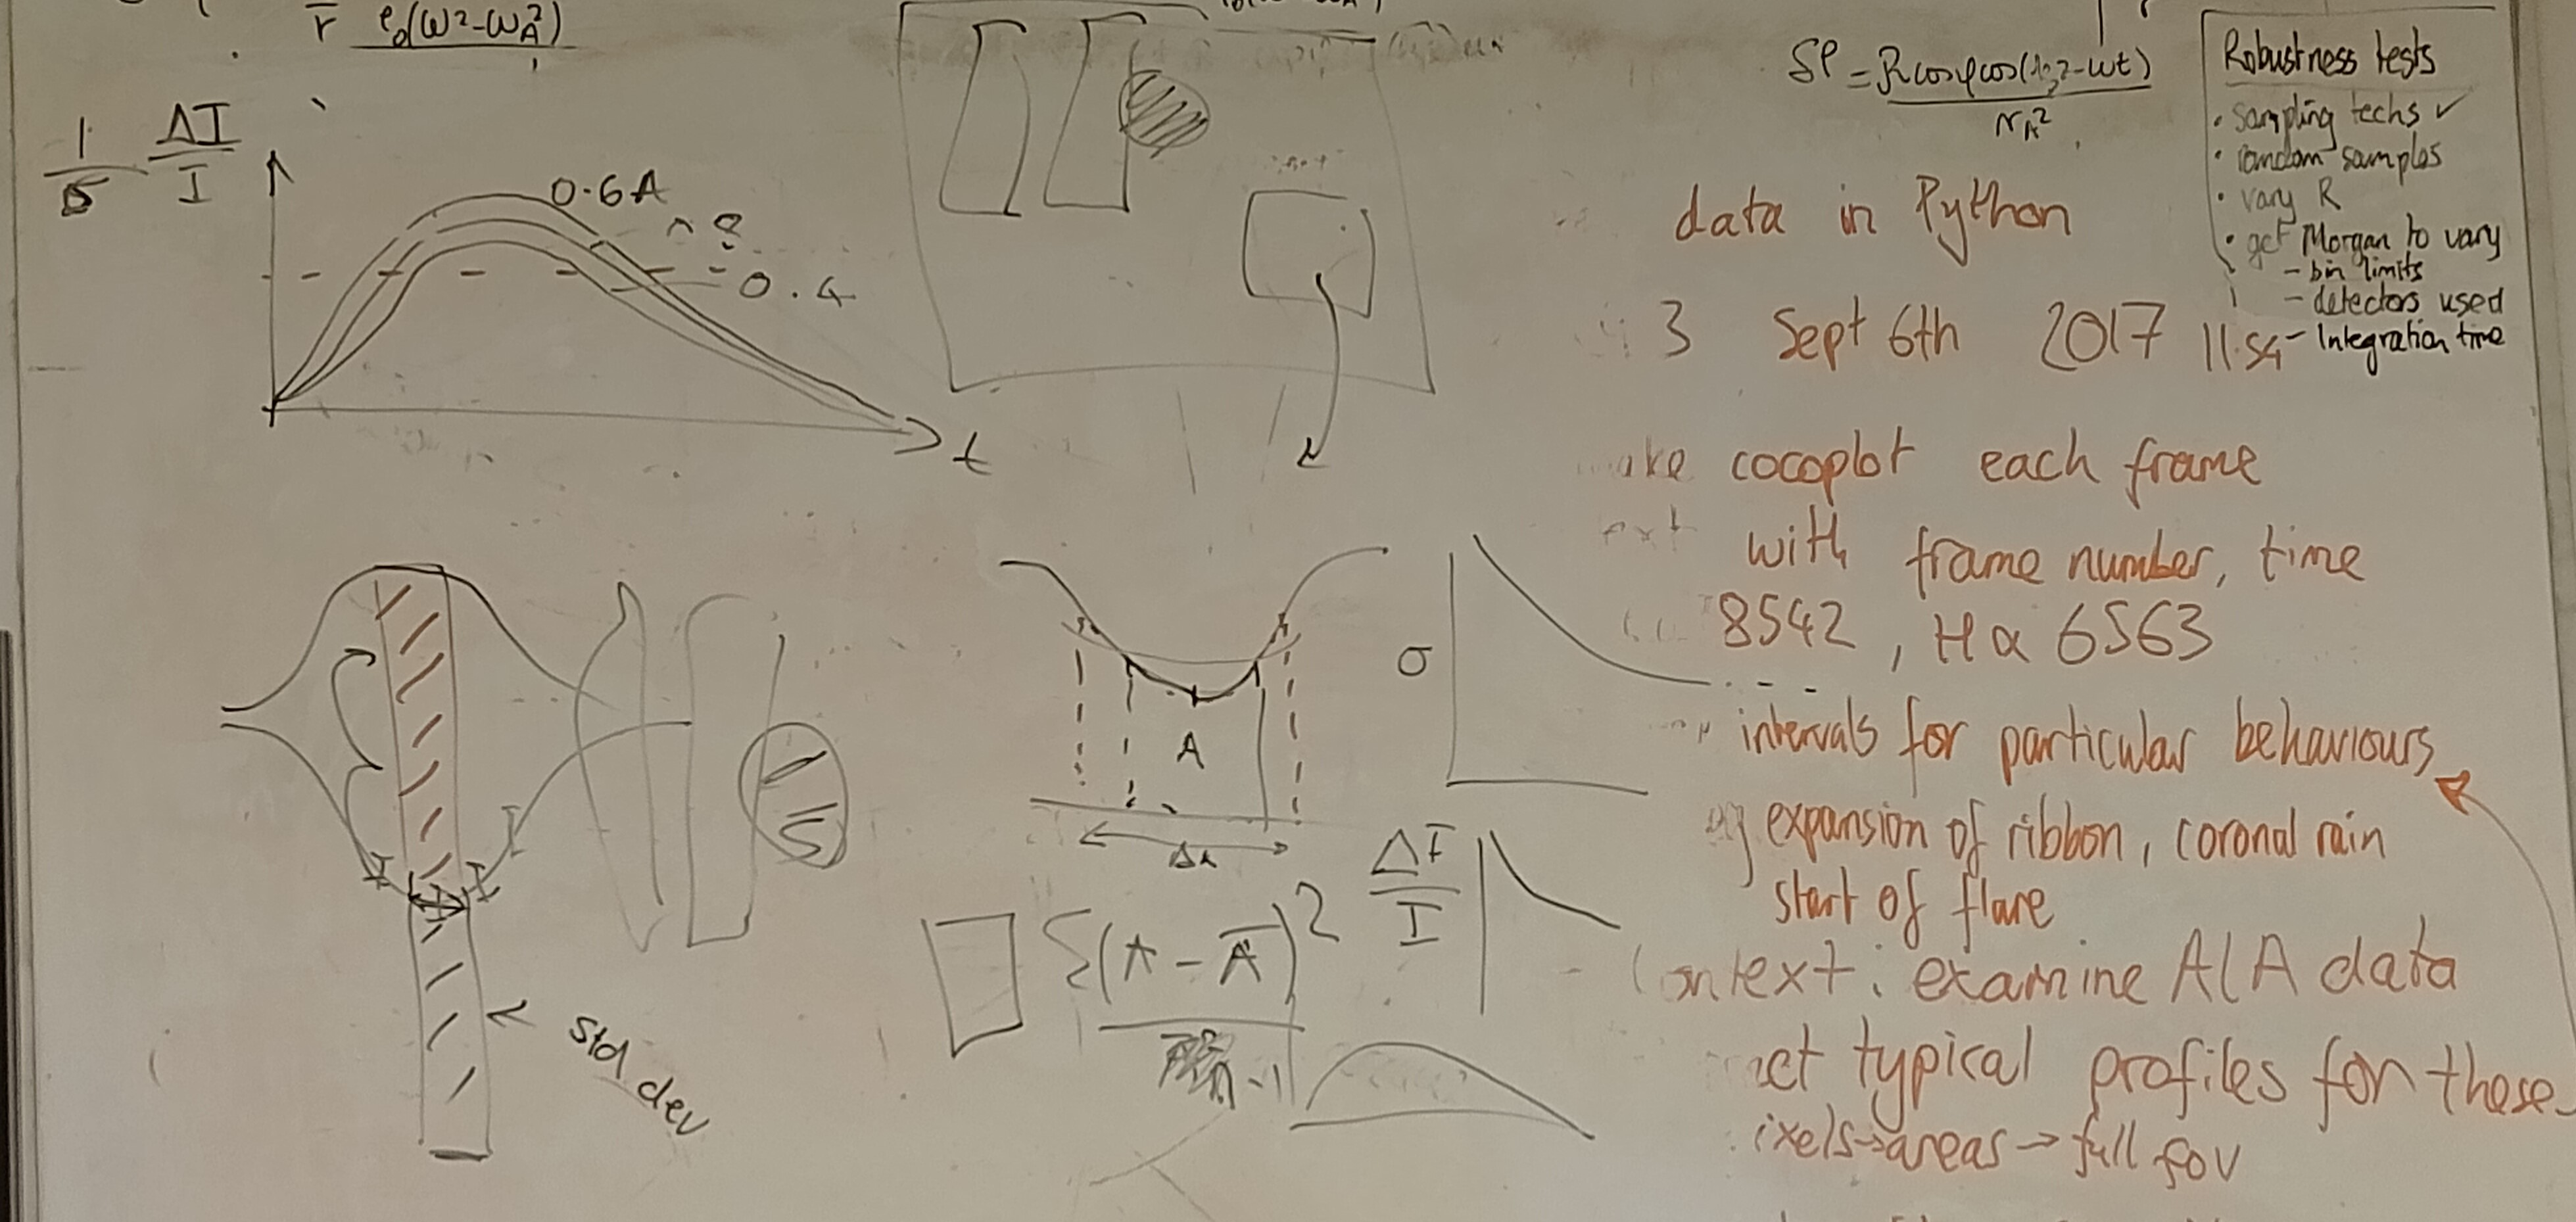

The goal is to find the best signal to noise ratio of detecting a flare by giving an optimal interval. Here we look at 
$$\frac{1}{\sigma}\frac{\Delta I}{I} $$
where $\sigma$ is the standard deviation of the spectrum in the interval PER UNIT AREA!(with following two options):

- Looking for an area $A$ under the interval with with $\Delta x$ for each pixel en then taking $\sum \frac{1}{n-1} (A - \bar{A})^2$
- looking at the standard deviation of the all of the wavelength values then averaging over those used in the interval. 

Remark: this has to be done per unit area or per pixel. 

Here we will display the standard devation for the two regimes for the Halpha line

D:\solar flares/data/2017-09-06\use_nessi.py:1439: RuntimeWarning: divide by zero encountered in scalar divide
  return np.nanstd(np.sum(self.datacube[frame,0,(wav<= interval[1]) &


D:\solar flares/data/2017-09-06\use_nessi.py:1430: RuntimeWarning: invalid value encountered in scalar divide
  std = integral / l_interv / appr_num**0.5


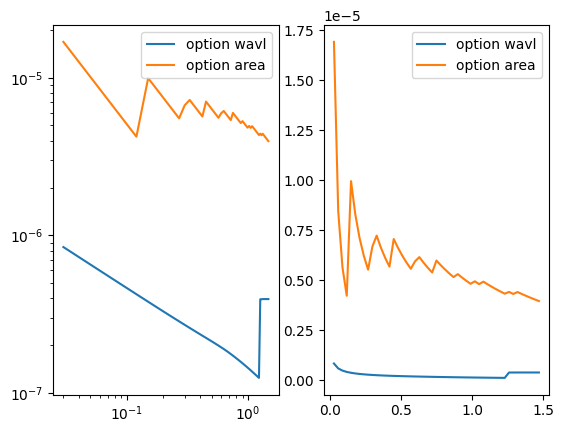

STD_Area = array([3.38511806e-05, 1.69255903e-05, 8.46279515e-06, 5.64186343e-06,
       4.23139757e-06, 9.96122556e-06, 8.30102130e-06, 7.11516112e-06,
       6.22576598e-06, 5.53401420e-06, 6.69264712e-06, 7.23756109e-06,
       6.63443100e-06, 6.12409015e-06, 5.68665514e-06, 7.06811079e-06,
       6.62635387e-06, 6.23656834e-06, 5.89009232e-06, 5.58008747e-06,
       5.95444097e-06, 6.16344926e-06, 5.88329247e-06, 5.62749715e-06,
       5.39301810e-06, 5.99173958e-06, 5.76128805e-06, 5.54790701e-06,
       5.34976748e-06, 5.16529274e-06, 5.31138489e-06, 5.14004989e-06,
       4.97942333e-06, 4.82853172e-06, 4.95311974e-06, 4.81160203e-06,
       4.93488078e-06, 4.80150562e-06, 4.67515021e-06, 4.55527456e-06,
       4.44139270e-06, 4.33306605e-06, 4.42278900e-06, 4.31993345e-06,
       4.41693863e-06, 4.31878443e-06, 4.22489782e-06, 4.13500637e-06,
       4.04886041e-06, 3.96623060e-06]), STD_Wavl = array([0.00000000e+00, 8.42343660e-07, 5.96374317e-07, 4.87547843e-07,
       4.22757

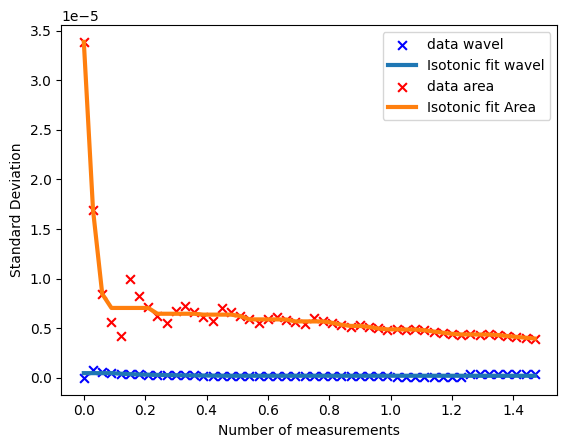

D:\solar flares/data/2017-09-06\use_nessi.py:1504: RuntimeWarning: invalid value encountered in scalar divide
  return Delta_i / I


The maximal signal to noise ratio for the area criterion is if the interval is of width $\Delta x=0.24\AA$.
at an intesity of 25.453445357007705. For a standard deviation of 6.464883878483931e-06.

The maximal signal to noise ratio for the wavl criterion is if the interval is of width $\Delta x=0.44999999999999996\AA$.
at an intesity of 644.4172643129278. For a standard deviation of 2.2324484482663208e-07.



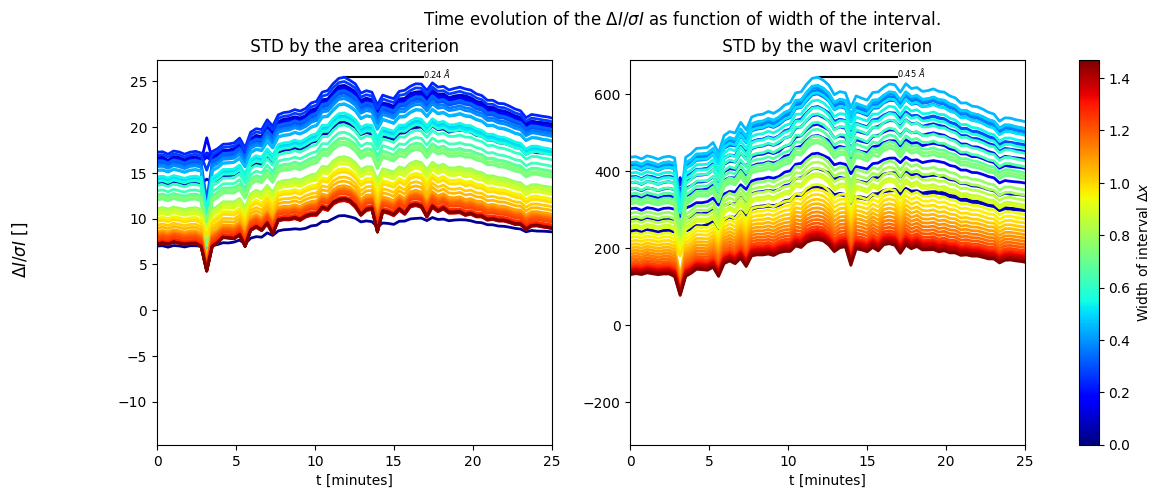

D:\solar flares/data/2017-09-06\use_nessi.py:1648: RuntimeWarning: All-NaN slice encountered
  MAX = np.nanmax(A, axis=1)


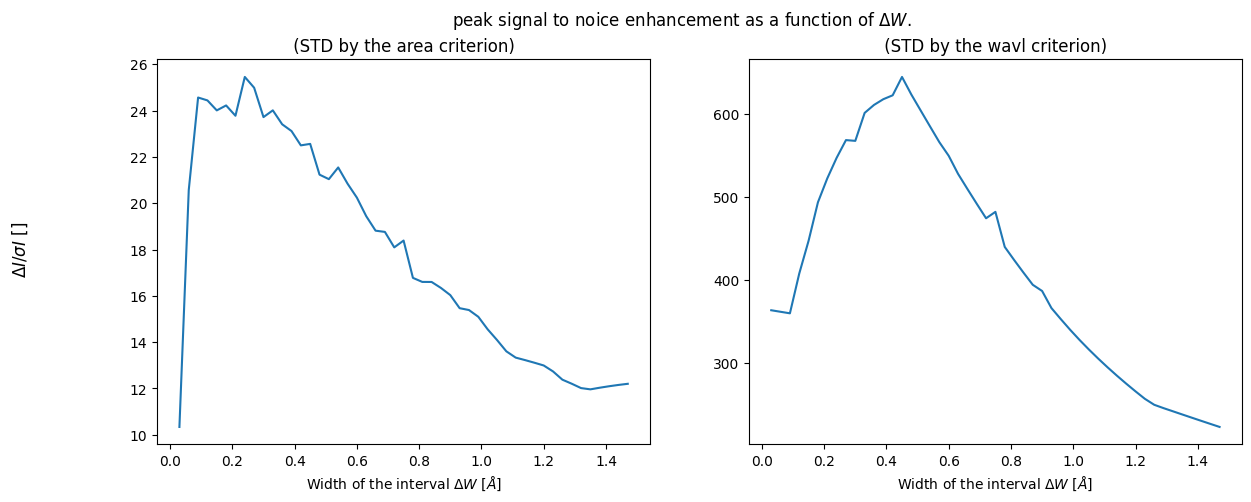

Directory 'line_data/optimal_width' already exists.


(array([[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [ 7.01078094,  7.04360395,  6.88257848, ...,  8.33309099,
          8.29802093,  8.33733388],
        [13.94895307, 14.01299718, 13.70208052, ..., 16.58531148,
         16.51219298, 16.59224508],
        ...,
        [ 7.20868758,  7.35306414,  7.21381246, ...,  9.77020647,
          9.60011618,  9.67132518],
        [ 7.21034233,  7.35855928,  7.21772739, ...,  9.80707458,
          9.63618437,  9.70871873],
        [ 7.20712397,  7.35932998,  7.21670861, ...,  9.83823445,
          9.66657783,  9.74051196]]),
 array([[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [246.4075405 , 247.56116924, 241.90161575, ..., 292.88270065,
         291.65009539, 293.0318254 ],
        [245.13155148, 246.25702907, 240.79314354, ..., 291.46152523,
         290.17657926, 291.58337267],
        ...,
        [137.20594601, 139.95392516,

In [35]:
Deltas=np.arange(0,1.5, 0.03)
un.analyse_optimal_interval(CaII, Deltas)

# saving Important small files for further analysis
We want the following:

* FOV_spectrum
* quiet_sun spectrum (nessi of qs)
* Full disk profile

In [36]:
un.save_for_further_analysis(CaII, theor_CaII)
